In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler

In [3]:
# Загрузка данных
data = pd.read_excel("DynamicData_for_prediction.xlsx")

In [4]:
# Выделение нужных столбцов
columns = ['X:I1', 'Y:I1', 'X:I2', 'Y:I2', 'X:I3', 'Y:I3', 'X:P1', 'Y:P1', 'X:P2', 'Y:P2', 'X:P3', 'Y:P3',
           'WOPR:P1', 'WOPR:P2', 'WOPR:P3']  # Дебит нефти нагнетающих скважин
data = data[columns]


In [5]:
# Преобразование координат в numpy array
coordinates = data[['X:I1', 'Y:I1', 'X:I2', 'Y:I2', 'X:I3', 'Y:I3', 'X:P1', 'Y:P1', 'X:P2', 'Y:P2', 'X:P3', 'Y:P3']].values


In [6]:
# Стандартизация данных
scaler = StandardScaler()
scaled_data = scaler.fit_transform(data)


In [7]:
# Разделение данных на признаки (координаты) и целевые переменные (дебит нефти нагнетающих скважин)
features = scaled_data[:, :-3]  # Координаты скважин
targets = scaled_data[:, -3:]  # Дебит нефти нагнетающих скважин


In [8]:
# Определение матрицы смежности на основе расстояния между скважинами
def adjacency_matrix(coordinates):
    num_wells = len(coordinates)
    adj_matrix = np.zeros((num_wells, num_wells))

    for i in range(num_wells):
        for j in range(i+1, num_wells):
            distance = np.linalg.norm(coordinates[i] - coordinates[j])
            adj_matrix[i, j] = 1 / (distance + 1e-6)  # Добавляем небольшое значение, чтобы избежать деления на ноль
            adj_matrix[j, i] = 1 / (distance + 1e-6)  # Матрица симметрична

    return adj_matrix

In [9]:
# Создание матрицы смежности
adj_matrix = adjacency_matrix(coordinates)

In [10]:
# Класс графовой нейронной сети
class GraphNeuralNetwork(nn.Module):
    def __init__(self):
        super(GraphNeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(12, 64)  # Изменяем размерность входных данных
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 3)

    def forward(self, x, adj_matrix):
        x = torch.relu(self.fc1(x))
        x = torch.matmul(adj_matrix, x)  # Умножение на матрицу смежности
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [18]:
# Создание экземпляра модели и определение функции потерь и оптимизатора
model = GraphNeuralNetwork()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.005)

In [19]:
# Преобразование данных в тензоры PyTorch
features_tensor = torch.tensor(features, dtype=torch.float32)
adj_matrix_tensor = torch.tensor(adj_matrix, dtype=torch.float32)
targets_tensor = torch.tensor(targets, dtype=torch.float32)


In [20]:
# Обучение модели
for epoch in range(200):
    optimizer.zero_grad()
    output = model(features_tensor, adj_matrix_tensor)
    loss = criterion(output, targets_tensor)
    loss.backward()
    optimizer.step()
    print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, 100, loss.item()))


Epoch [1/100], Loss: 3190793437184.0000
Epoch [2/100], Loss: 583044694016.0000
Epoch [3/100], Loss: 1027655532544.0000
Epoch [4/100], Loss: 595658670080.0000
Epoch [5/100], Loss: 189462577152.0000
Epoch [6/100], Loss: 253772316672.0000
Epoch [7/100], Loss: 468773601280.0000
Epoch [8/100], Loss: 478433443840.0000
Epoch [9/100], Loss: 296927985664.0000
Epoch [10/100], Loss: 107541151744.0000
Epoch [11/100], Loss: 37014695936.0000
Epoch [12/100], Loss: 81315192832.0000
Epoch [13/100], Loss: 148377255936.0000
Epoch [14/100], Loss: 162545270784.0000
Epoch [15/100], Loss: 126701944832.0000
Epoch [16/100], Loss: 73342607360.0000
Epoch [17/100], Loss: 38934511616.0000
Epoch [18/100], Loss: 38294958080.0000
Epoch [19/100], Loss: 59889582080.0000
Epoch [20/100], Loss: 78935064576.0000
Epoch [21/100], Loss: 80047988736.0000
Epoch [22/100], Loss: 65452175360.0000
Epoch [23/100], Loss: 39353970688.0000
Epoch [24/100], Loss: 15927150592.0000
Epoch [25/100], Loss: 3635677696.0000
Epoch [26/100], Loss

In [21]:
# Тестирование модели (предсказание дебита нефти для нагнетающих скважин)
model.eval()
with torch.no_grad():
    output = model(features_tensor, adj_matrix_tensor)
    print("Predictions (scaled):", output)


Predictions (scaled): tensor([[-32.9301,  29.5182,  -7.0887],
        [-32.9301,  29.5182,  -7.0887],
        [-32.9301,  29.5182,  -7.0887],
        [-32.9301,  29.5182,  -7.0887],
        [-32.9301,  29.5182,  -7.0887],
        [-32.9301,  29.5182,  -7.0887],
        [-32.9301,  29.5182,  -7.0887],
        [-32.9301,  29.5182,  -7.0887],
        [-32.9301,  29.5182,  -7.0887],
        [-32.9301,  29.5182,  -7.0887],
        [-32.9301,  29.5182,  -7.0887],
        [-32.9301,  29.5182,  -7.0887],
        [-33.0551,  29.6432,  -6.9012],
        [-33.0551,  29.6432,  -6.9012],
        [-33.0551,  29.6432,  -6.9012],
        [-32.9301,  29.5182,  -7.0887],
        [-32.9301,  29.5182,  -7.0887],
        [-32.9301,  29.5182,  -7.0887],
        [-32.9301,  29.5182,  -7.0887],
        [-32.9301,  29.5182,  -7.0887],
        [-32.9301,  29.5182,  -7.0887],
        [-32.9301,  29.5182,  -7.0887],
        [-32.9301,  29.5182,  -7.0887],
        [-32.9301,  29.5182,  -7.0887],
        [-32.9301,

In [22]:
# Обратное преобразование стандартизованных предсказанных значений в исходный масштаб
predictions = scaler.inverse_transform(np.hstack((features, output.numpy())))
print("Predictions (original scale):", predictions[:, -3:])

Predictions (original scale): [[-2231.43841161  1361.67765417  -273.24836454]
 [-2231.43841161  1361.67765417  -273.24836454]
 [-2231.43841161  1361.67765417  -273.24836454]
 [-2231.43841161  1361.67765417  -273.24836454]
 [-2231.43841161  1361.67765417  -273.24836454]
 [-2231.43841161  1361.67765417  -273.24836454]
 [-2231.43841161  1361.67765417  -273.24836454]
 [-2231.43841161  1361.67765417  -273.24836454]
 [-2231.43841161  1361.67765417  -273.24836454]
 [-2231.43841161  1361.67765417  -273.24836454]
 [-2231.43841161  1361.67765417  -273.24836454]
 [-2231.43841161  1361.67765417  -273.24836454]
 [-2240.11981445  1367.20377216  -264.76903137]
 [-2240.11981445  1367.20377216  -264.76903137]
 [-2240.11981445  1367.20377216  -264.76903137]
 [-2231.43841161  1361.67765417  -273.24836454]
 [-2231.43841161  1361.67765417  -273.24836454]
 [-2231.43841161  1361.67765417  -273.24836454]
 [-2231.43841161  1361.67765417  -273.24836454]
 [-2231.43841161  1361.67765417  -273.24836454]
 [-2231.43

In [23]:
import matplotlib.pyplot as plt

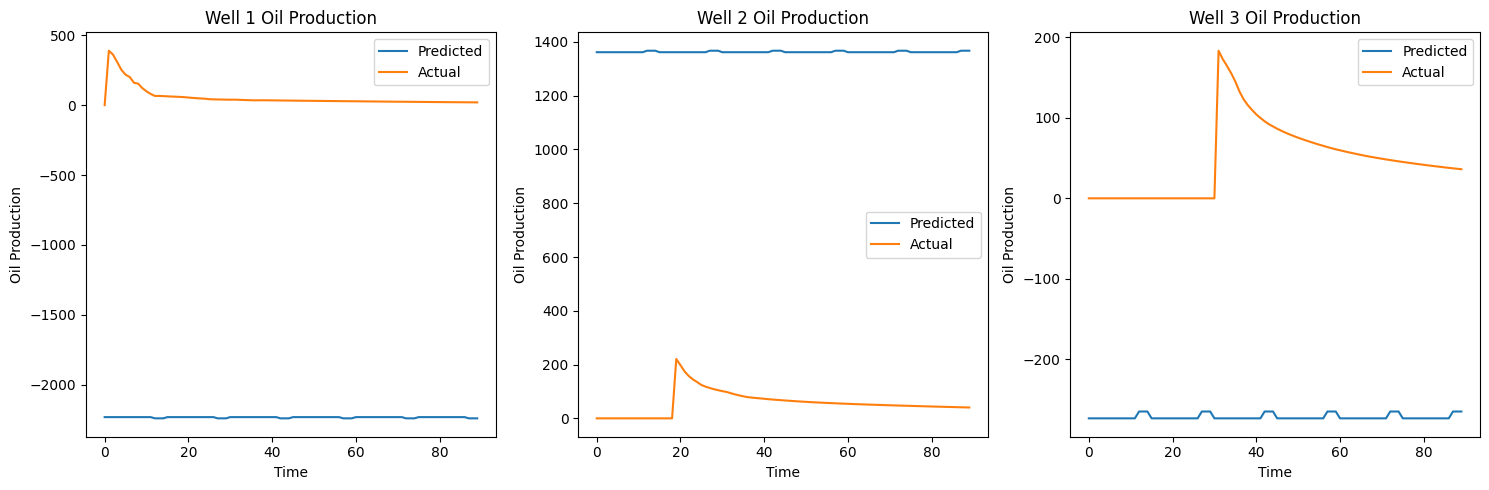

In [24]:
# Преобразование предсказанных и фактических значений обратно в исходный масштаб
predictions_original_scale = scaler.inverse_transform(np.hstack((features, output.numpy())))
actual_values_original_scale = scaler.inverse_transform(np.hstack((features, targets)))

# Построение графиков
plt.figure(figsize=(15, 5))
for i in range(3):  # Цикл по нагнетающим скважинам
    plt.subplot(1, 3, i+1)
    plt.plot(predictions_original_scale[:, -3:][:, i], label='Predicted')
    plt.plot(actual_values_original_scale[:, -3:][:, i], label='Actual')
    plt.title(f'Well {i+1} Oil Production')
    plt.xlabel('Time')
    plt.ylabel('Oil Production')
    plt.legend()
plt.tight_layout()
plt.show()